In [7]:
import sys

import numpy as np
import pandas as pd
import pywt
import random


import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns


sys.path.append('../..')

from utils.predict import *

In [8]:
def load_aimed_service(df, selected_ids):
    # 提取包含所选id的所有行
    selected_rows = []
    for selected_id in selected_ids:
        # 或者使用 df.loc[df['msinstanceid'] == selected_id]
        rows = df.query('msinstanceid == @selected_id')
        selected_rows.append(rows)

    # 将提取的行组合成一个新的DataFrame
    selected_rows_df = pd.concat(selected_rows)
    return selected_rows_df
    
# 小波滤噪
def wavelet_denoising(data):
    # 小波函数取db8
    db4 = pywt.Wavelet('db8')

    # 分解
    coeffs = pywt.wavedec(data, db4)
    # 高频系数置零
    coeffs[len(coeffs) - 1] *= 0.3
    coeffs[len(coeffs) - 2] *= 0.3
    # 重构
    meta = pywt.waverec(coeffs, db4)
    meta = meta[:len(data)]
    return meta


def supplement_feature(df, K):
    df["Polyfit_HTTP_RT"] = df['HTTP_RT'].rolling(window=K).apply(lambda y: np.polyfit(range(K), y, 1)[0] if len(y.dropna()) == K else np.nan)
    df["Mean_HTTP_RT"] = df['HTTP_RT'].rolling(window=K).mean()
    df["Median_HTTP_RT"] = df['HTTP_RT'].rolling(window=K).median()

    df["HTTP_RT"] = wavelet_denoising(df["HTTP_RT"])

    df_no_nan = df.dropna()
    return df_no_nan

def split_array_by_step(df, K):
    if len(df) == 0:
        return []
    # supplement more feature
    more_feature_df = supplement_feature(df, K)
    more_feature_df = more_feature_df[["HTTP_RT", "Polyfit_HTTP_RT", "Mean_HTTP_RT", "Median_HTTP_RT"]]

    if len(more_feature_df) == 0:
        return []

    # normalizate 归一化
    scaler = MinMaxScaler()
    more_feature_df[["HTTP_RT", "Polyfit_HTTP_RT", "Mean_HTTP_RT", "Median_HTTP_RT"]] = scaler.fit_transform(more_feature_df[["HTTP_RT", "Polyfit_HTTP_RT", "Mean_HTTP_RT", "Median_HTTP_RT"]])
    # 遍历 DataFrame 的每一行，跳过前 K 行
    result = []
    for i in range(0, len(more_feature_df) - K, 1):
        window = more_feature_df.iloc[i:i + K]
        result.append(window)

    return result,scaler

# 将数据转换为LSTM模型的输入形式
def create_sequences(data, time_steps=1):
    xs, ys = [], []
    for i in range(len(data)):
        xs.append(data[i][:time_steps])
        ys.append(data[i][time_steps])
    return np.array(xs), np.array(ys)


In [9]:
################################################################################
# Data preparation stage
################################################################################

chunksize = 10000

reader = pd.read_csv("/data/hmn_data/alibaba_cluster_data/MSRT_Resource.csv", chunksize=chunksize)

tmp_df = pd.DataFrame()
for _, chunk in enumerate(reader):
    tmp_df = pd.concat([tmp_df, chunk])


In [10]:
# 获取所有唯一的id值
unique_ids = tmp_df['msinstanceid'].unique()

In [75]:
# 从唯一的id值中随机选择一个，不放回
test_ids = np.random.choice(unique_ids, 1, replace=False)

In [76]:
test_df = load_aimed_service(tmp_df, test_ids)
test_df=test_df[:200]

In [77]:
TIME_STEP=5


In [78]:
test_http_rt_df,scaler = split_array_by_step(test_df, TIME_STEP + 1)

# Using np.stack to stack the list of arrays in a new dimension
test_workload = np.stack([df.values for df in test_http_rt_df], axis=0)


In [79]:
test_workload.shape

(189, 6, 4)

In [80]:
x_test, y_test = create_sequences(test_workload, TIME_STEP)

In [81]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# device = torch.device('cpu')

In [82]:
from LSTM.LSTM import LSTMModel


model_path="../../data/model/LSTM.pt"
lstm_model = LSTMModel(input_dim=4, output_dim=4, hidden_dim=64, num_layers=1).to(device)

lstm_model.load_state_dict(torch.load(model_path))  # load the weights
lstm_model.eval()  # set the model to evaluation mode

lstm_pred = predict(lstm_model, x_test, device)

In [83]:
from Bi_LSTM.Bi_LSTM import BiLSTMModel

model_path="../../data/model/BI-LSTM.pt"
bi_lstm_model = BiLSTMModel(input_dim=4, output_dim=4, hidden_dim=16, num_layers=2).to(device)
   
bi_lstm_model.load_state_dict(torch.load(model_path))  # load the weights
bi_lstm_model.eval()  # set the model to evaluation mode

bi_lstm_pred = predict(bi_lstm_model, x_test, device)

In [84]:
from Bi_LSTM_Attention.BI_LSTM_Attention import BiLSTMAttentionModel

model_path="../../data/model/BI-LSTM-Attention.pt"
attention_model = BiLSTMAttentionModel(input_dim=4, output_dim=4, hidden_dim=64, num_layers=1).to(device)

attention_model.load_state_dict(torch.load(model_path))  # load the weights
attention_model.eval()  # set the model to evaluation mode

attention_x_test = np.transpose(x_test, (0, 2, 1))

bi_lstm_attention_pred = predict(attention_model, attention_x_test, device)

In [85]:
from N_Beats.N_Beats import NBeatsModel

model_path="../../data/model/N-Beats.pt"
n_beats_model = NBeatsModel.model(input_dim=TIME_STEP, output_dim=1, nb_blocks_per_stack=4, thetas_dim=4, hidden_size=32)

n_beats_model.load_state_dict(torch.load(model_path))  # load the weights
n_beats_model.eval()  # set the model to evaluation mode

n_beats_pred = NBeatsModel.predict(n_beats_model, x_test[:, :, :1], device)

| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=True)
     | -- GenericBlock(units=32, thetas_dim=4, backcast_length=5, forecast_length=1, share_thetas=False) at @139719592237136
     | -- GenericBlock(units=32, thetas_dim=4, backcast_length=5, forecast_length=1, share_thetas=False) at @139719592237136
     | -- GenericBlock(units=32, thetas_dim=4, backcast_length=5, forecast_length=1, share_thetas=False) at @139719592237136
     | -- GenericBlock(units=32, thetas_dim=4, backcast_length=5, forecast_length=1, share_thetas=False) at @139719592237136
| --  Stack Generic (#1) (share_weights_in_stack=True)
     | -- GenericBlock(units=32, thetas_dim=4, backcast_length=5, forecast_length=1, share_thetas=False) at @139719589722912
     | -- GenericBlock(units=32, thetas_dim=4, backcast_length=5, forecast_length=1, share_thetas=False) at @139719589722912
     | -- GenericBlock(units=32, thetas_dim=4, backcast_length=5, forecast_length=1, share_thetas=False) at @139719589722912
     

In [86]:
pred_tensors = [
    {"model_name": "LSTM", "tensor": torch.tensor(lstm_pred[:, :1]), "color": "green"},
    {"model_name": "Bi-LSTM", "tensor": torch.tensor(bi_lstm_pred[:, :1]), "color": "orange"},
    {"model_name": "Bi-LSTM-Attention", "tensor": torch.tensor(bi_lstm_attention_pred[:, :1]), "color": "brown"},
    {"model_name": "N-Beats", "tensor": torch.tensor(n_beats_pred), "color": "red"},
]
actual_tensor = torch.tensor(y_test[:, :1])

# MSE
MSE_Loss(pred_tensors, actual_tensor)
print()
# MAE
MAE_Loss(pred_tensors, actual_tensor)
print()
# MAPE
MAPE_Loss(pred_tensors, actual_tensor)
print()
# RMSE
RMSE_Loss(pred_tensors, actual_tensor)
print()

LSTM MSE Validation Loss: 0.026012
Bi-LSTM MSE Validation Loss: 0.032437
Bi-LSTM-Attention MSE Validation Loss: 0.017269
N-Beats MSE Validation Loss: 0.026951

LSTM MAE Validation Loss: 0.126775
Bi-LSTM MAE Validation Loss: 0.145264
Bi-LSTM-Attention MAE Validation Loss: 0.103982
N-Beats MAE Validation Loss: 0.129477

LSTM MAPE Validation Loss: 33.792211%
Bi-LSTM MAPE Validation Loss: 39.735156%
Bi-LSTM-Attention MAPE Validation Loss: 31.441057%
N-Beats MAPE Validation Loss: 34.384256%

LSTM RMSE Validation Loss: 0.161281
Bi-LSTM RMSE Validation Loss: 0.180103
Bi-LSTM-Attention RMSE Validation Loss: 0.131413
N-Beats RMSE Validation Loss: 0.164168



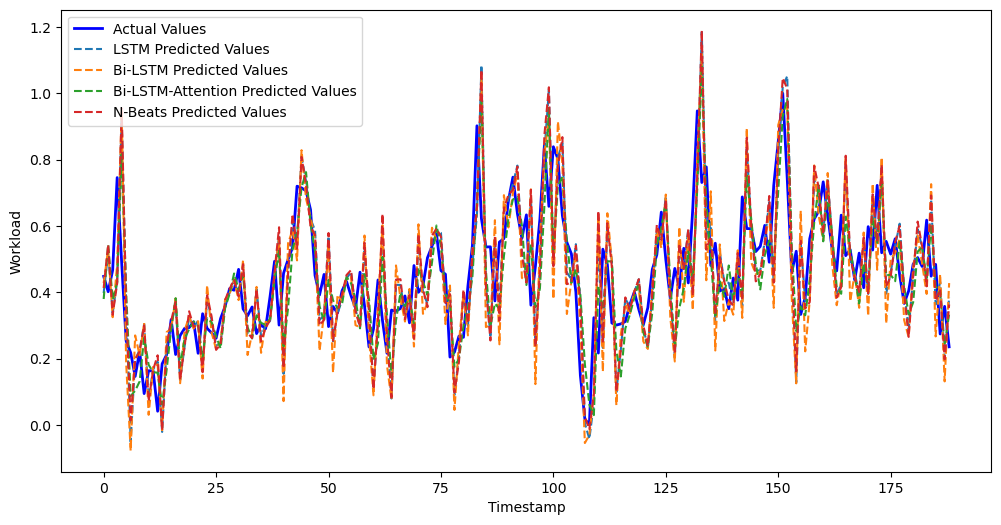

In [87]:
random_str = ''.join(random.sample('abcdefghijklmnopqrstuvwxyz',5))

plot_predictions(pred_tensors, actual_tensor,"./img/"+random_str+".jpg")    

In [88]:
tmp=np.repeat(lstm_pred[:, :1], 4, axis=1)
lstm_pred_inverse = scaler.inverse_transform(tmp)

tmp=np.repeat(bi_lstm_pred[:, :1], 4, axis=1)
bi_lstm_pred_inverse = scaler.inverse_transform(tmp)

tmp=np.repeat(bi_lstm_attention_pred[:, :1], 4, axis=1)
bi_lstm_attention_pred_inverse = scaler.inverse_transform(tmp)

tmp= np.repeat(n_beats_pred, 4, axis=1)
n_beats_pred_inverse = scaler.inverse_transform(tmp)


In [89]:
pred_tensors = [
    {"model_name": "LSTM", "tensor": torch.tensor(lstm_pred_inverse[:, :1]), "color": "green"},
    {"model_name": "Bi-LSTM", "tensor": torch.tensor(bi_lstm_pred_inverse[:, :1]), "color": "orange"},
    {"model_name": "Bi-LSTM-Attention", "tensor": torch.tensor(bi_lstm_attention_pred_inverse[:, :1]), "color": "brown"},
    {"model_name": "N-Beats", "tensor": torch.tensor(n_beats_pred_inverse[:, :1]), "color": "red"},
]
actual_tensor = torch.tensor(y_test[:, :1])

# MSE
MSE_Loss(pred_tensors, actual_tensor)
print()
# MAE
MAE_Loss(pred_tensors, actual_tensor)
print()
# MAPE
MAPE_Loss(pred_tensors, actual_tensor)
print()
# RMSE
RMSE_Loss(pred_tensors, actual_tensor)
print()

LSTM MSE Validation Loss: 31.728972
Bi-LSTM MSE Validation Loss: 31.020753
Bi-LSTM-Attention MSE Validation Loss: 30.704066
N-Beats MSE Validation Loss: 31.837424

LSTM MAE Validation Loss: 5.572574
Bi-LSTM MAE Validation Loss: 5.500466
Bi-LSTM-Attention MAE Validation Loss: 5.500587
N-Beats MAE Validation Loss: 5.581164

LSTM MAPE Validation Loss: 1564.455129%
Bi-LSTM MAPE Validation Loss: 1540.700903%
Bi-LSTM-Attention MAPE Validation Loss: 1568.960118%
N-Beats MAPE Validation Loss: 1570.074547%

LSTM RMSE Validation Loss: 5.632848
Bi-LSTM RMSE Validation Loss: 5.569628
Bi-LSTM-Attention RMSE Validation Loss: 5.541125
N-Beats RMSE Validation Loss: 5.642466



FileNotFoundError: [Errno 2] No such file or directory: './data/img/result.jpg'

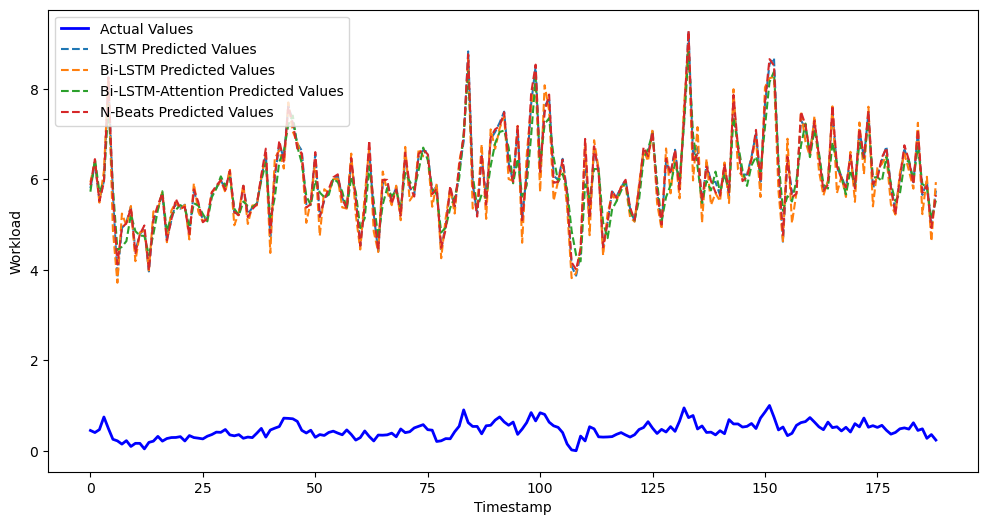

In [90]:
random_str = ''.join(random.sample('abcdefghijklmnopqrstuvwxyz',5))

plot_predictions(pred_tensors, actual_tensor)    